# Configuration

## Import Libraries

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
import time

# Suppress unnecessary warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Import Torch2PC Library

In [29]:
try:
    from Torch2PC import TorchSeq2PC as T2PC
except ImportError:
    print("Cloning Torch2PC repository...")
    import subprocess
    subprocess.run(["git", "clone", "-q", "https://github.com/RobertRosenbaum/Torch2PC.git"])
    from Torch2PC import TorchSeq2PC as T2PC
print("Torch2PC imported successfully.")

Torch2PC imported successfully.


## Set random seeds

In [30]:
torch.manual_seed(42)
np.random.seed(42)

## GPU Setup

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Code will run on: {device}")

Code will run on: cuda


## Data Loader

In [32]:
 def load_mnist_data():
    """Load and preprocess the MNIST dataset."""
    # Define pre process
    mnist_transform = transforms.Compose([
        transforms.Resize((32, 32)), # resize from 28x28
        transforms.ToTensor(), #  Converts the image to PyTorch tensors
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values using the M and DE of the MNIST dataset. This helps stabilize training
    ])

    # Download the data (train and test)
    train_val_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transform, download=True)
    # Split train data into train (90%) and validation (10%)
    train_size = int(0.9 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])
    # Define DataLoader instances with proper BATCH_SIZE and shuffle=True to prevent the model from learning the order of the data
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    # Stablish the class names (0 to 9)
    class_names = [str(i) for i in range(10)]
    return train_loader, val_loader, test_loader, class_names


# Define Model

## Hyperparameters

In [33]:
# General
LATENT_DIM = 84
NUM_CLASSES = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 15

# Predictive Coding Specific Hyperparameters
N_INFERENCE_STEPS = 5
INFERENCE_LEARNING_RATE = 5e-5

## Model Architecture

In [34]:
def create_model():
    """Creates a fresh instance of the CNN architecture."""
    return nn.Sequential(
        nn.Sequential(nn.Conv2d(1, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2)),
        nn.Sequential(nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2)),
        nn.Sequential(nn.Flatten(), nn.Linear(16 * 5 * 5, 120), nn.ReLU()),
        nn.Sequential(nn.Linear(120, LATENT_DIM), nn.ReLU()),
        nn.Sequential(nn.Linear(LATENT_DIM, NUM_CLASSES))
    )

# Training Functions

## Backpropagation

In [35]:
def train_model_backprop(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """Train the CNN model using standard backpropagation."""
    history = {'train_losses': [], 'train_accuracies': [], 
               'val_losses': [], 'val_accuracies': [], 
               'epoch_times':[], 'total_time':0.0}
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print(f"\nStarting standard backpropagation training...")
    print("-" * 60)
    
    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data) # Forward Pass
            loss = criterion(outputs, targets)
            loss.backward() # Backward Pass
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
        
        history['train_losses'].append(running_loss / len(train_loader))
        history['train_accuracies'].append(100.0 * correct_predictions / total_samples)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        history['val_losses'].append(val_loss / len(val_loader))
        history['val_accuracies'].append(100.0 * val_correct / val_total)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        history['epoch_times'].append(epoch_duration)

        print((f"Epoch [{epoch+1:02d}/{num_epochs}] -> "
               f"Train Loss: {history['train_losses'][-1]:.4f}, " 
               f"Train Acc: {history['train_accuracies'][-1]:.2f}% | " 
               f"Val Loss: {history['val_losses'][-1]:.4f}, " 
               f"Val Acc: {history['val_accuracies'][-1]:.2f}% | " 
               f"Time: {epoch_duration:.2f}s"))    
    
    total_end_time = time.time()
    history['total_time'] = total_end_time - total_start_time
    
    print("\nBackpropagation training completed!")
    print(f"Total training time: {history['total_time']:.2f} seconds ⏱️")
    
    return history

# Predictive Coding

In [38]:
def train_model_pc(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """Train the CNN model using Predictive Coding (Strict)."""
    history = {'train_losses': [], 'train_accuracies': [], 
               'val_losses': [], 'val_accuracies': [],
               'epoch_times':[], 'total_time': 0.0}
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\nStarting Predictive Coding training...")
    print(f"Using eta={INFERENCE_LEARNING_RATE} and n={N_INFERENCE_STEPS} inference iterations.")
    print("-" * 60)
    
    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            targets_onehot = F.one_hot(targets, num_classes=NUM_CLASSES).float()
            vhat, loss, _, _, _ = T2PC.PCInfer(
                model, criterion, data, targets_onehot, "Strict", 
                eta=INFERENCE_LEARNING_RATE, n=N_INFERENCE_STEPS
            )
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            _, predicted_labels = torch.max(vhat[-1].data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted_labels == targets).sum().item()
            
        history['train_losses'].append(running_loss / len(train_loader))
        history['train_accuracies'].append(100.0 * correct_predictions / total_samples)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                targets_onehot = F.one_hot(targets, num_classes=NUM_CLASSES).float()
                loss = criterion(outputs, targets_onehot)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        history['val_losses'].append(val_loss / len(val_loader))
        history['val_accuracies'].append(100.0 * val_correct / val_total)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        history['epoch_times'].append(epoch_duration)
        
        print((f"Epoch [{epoch+1:02d}/{num_epochs}] -> "
               f"Train Loss: {history['train_losses'][-1]:.4f}, "
               f"Train Acc: {history['train_accuracies'][-1]:.2f}% | " 
               f"Val Loss: {history['val_losses'][-1]:.4f}, "
               f"Val Acc: {history['val_accuracies'][-1]:.2f}% | "
               f"Time: {epoch_duration:.2f}s"))

    total_end_time = time.time()
    history['total_time'] = total_end_time - total_start_time
    
    print("\nPredictive Coding training completed!")
    print(f"Total training time: {history['total_time']:.2f} seconds ⏱️")
    
    return history

# Execution

In [39]:
# Load Data
train_loader, val_loader, test_loader, class_names = load_mnist_data()

# Backpropagation Run
bp_model = create_model().to(device)
bp_history = train_model_backprop(bp_model, train_loader, val_loader)

# Predictive Coding Run 
pc_model = create_model().to(device)
pc_history = train_model_pc(pc_model, train_loader, val_loader)


Starting standard backpropagation training...
------------------------------------------------------------
Epoch [01/15] -> Train Loss: 0.1872, Train Acc: 94.23% | Val Loss: 0.0930, Val Acc: 96.93% | Time: 17.03s
Epoch [02/15] -> Train Loss: 0.0586, Train Acc: 98.18% | Val Loss: 0.0595, Val Acc: 98.10% | Time: 16.84s
Epoch [03/15] -> Train Loss: 0.0415, Train Acc: 98.73% | Val Loss: 0.0528, Val Acc: 98.47% | Time: 17.34s
Epoch [04/15] -> Train Loss: 0.0340, Train Acc: 98.94% | Val Loss: 0.0657, Val Acc: 98.02% | Time: 17.40s
Epoch [05/15] -> Train Loss: 0.0281, Train Acc: 99.10% | Val Loss: 0.0458, Val Acc: 98.87% | Time: 17.59s
Epoch [06/15] -> Train Loss: 0.0232, Train Acc: 99.27% | Val Loss: 0.0450, Val Acc: 98.72% | Time: 17.29s
Epoch [07/15] -> Train Loss: 0.0187, Train Acc: 99.42% | Val Loss: 0.0492, Val Acc: 98.57% | Time: 17.17s
Epoch [08/15] -> Train Loss: 0.0181, Train Acc: 99.40% | Val Loss: 0.0479, Val Acc: 98.80% | Time: 17.03s
Epoch [09/15] -> Train Loss: 0.0152, Train A

# Plots

In [42]:
def plot_comparison(bp_history, pc_history):
    """Generates the 2x3 comparison plot matrix."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    epochs = range(1, NUM_EPOCHS + 1)

    # --- Row 1: Backpropagation Results ---
    axes[0, 0].plot(epochs, bp_history['train_losses'], 'b-o', label='Train Loss')
    axes[0, 0].plot(epochs, bp_history['val_losses'], 'r-s', label='Val Loss')
    axes[0, 0].set_title('Backpropagation: Loss vs. Epoch')
    axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss'); axes[0, 0].legend(); axes[0, 0].grid(False)
    
    axes[1, 0].plot(epochs, bp_history['train_accuracies'], 'b-o', label='Train Accuracy')
    axes[1, 0].plot(epochs, bp_history['val_accuracies'], 'r-s', label='Val Accuracy')
    axes[1, 0].set_title('Backpropagation: Accuracy vs. Epoch')
    axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Accuracy (%)'); axes[1, 0].legend(); axes[1, 0].grid(False)

    # --- Row 2: Predictive Coding Results ---
    axes[0, 1].plot(epochs, pc_history['train_losses'], 'b-o', label='Train Loss')
    axes[0, 1].plot(epochs, pc_history['val_losses'], 'r-s', label='Val Loss')
    axes[0, 1].set_title('Predictive Coding: Loss vs. Epoch')
    axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('Loss'); axes[0, 1].legend(); axes[0, 1].grid(False)
    
    axes[1, 1].plot(epochs, pc_history['train_accuracies'], 'b-o', label='Train Accuracy')
    axes[1, 1].plot(epochs, pc_history['val_accuracies'], 'r-s', label='Val Accuracy')
    axes[1, 1].set_title('Predictive Coding: Accuracy vs. Epoch')
    axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('Accuracy (%)'); axes[1, 1].legend(); axes[1, 1].grid(False)

    # --- Row 3: Combined Results ---
    axes[0, 2].plot(epochs, bp_history['train_losses'], 'b-o', label='BP Train Loss')
    axes[0, 2].plot(epochs, bp_history['val_losses'], 'r-s', label='BP Val Loss')
    axes[0, 2].plot(epochs, pc_history['train_losses'], 'b--o', label='PC Train Loss')
    axes[0, 2].plot(epochs, pc_history['val_losses'], 'r--s', label='PC Val Loss')
    axes[0, 2].set_title('Combined: Loss vs. Epoch')
    axes[0, 2].set_xlabel('Epoch'); axes[0, 2].set_ylabel('Loss'); axes[0, 2].legend(); axes[0, 2].grid(False)
    
    axes[1, 2].plot(epochs, bp_history['train_accuracies'], 'b-o', label='BP Train Acc')
    axes[1, 2].plot(epochs, bp_history['val_accuracies'], 'r-s', label='BP Val Acc')
    axes[1, 2].plot(epochs, pc_history['train_accuracies'], 'b--o', label='PC Train Acc')
    axes[1, 2].plot(epochs, pc_history['val_accuracies'], 'r--s', label='PC Val Acc')
    axes[1, 2].set_title('Combined: Accuracy vs. Epoch')
    axes[1, 2].set_xlabel('Epoch'); axes[1, 2].set_ylabel('Accuracy (%)'); axes[1, 2].legend(); axes[1, 2].grid(False)

    plt.tight_layout()
    plt.savefig('comparison_plot_2.png', dpi=300)
    plt.show()

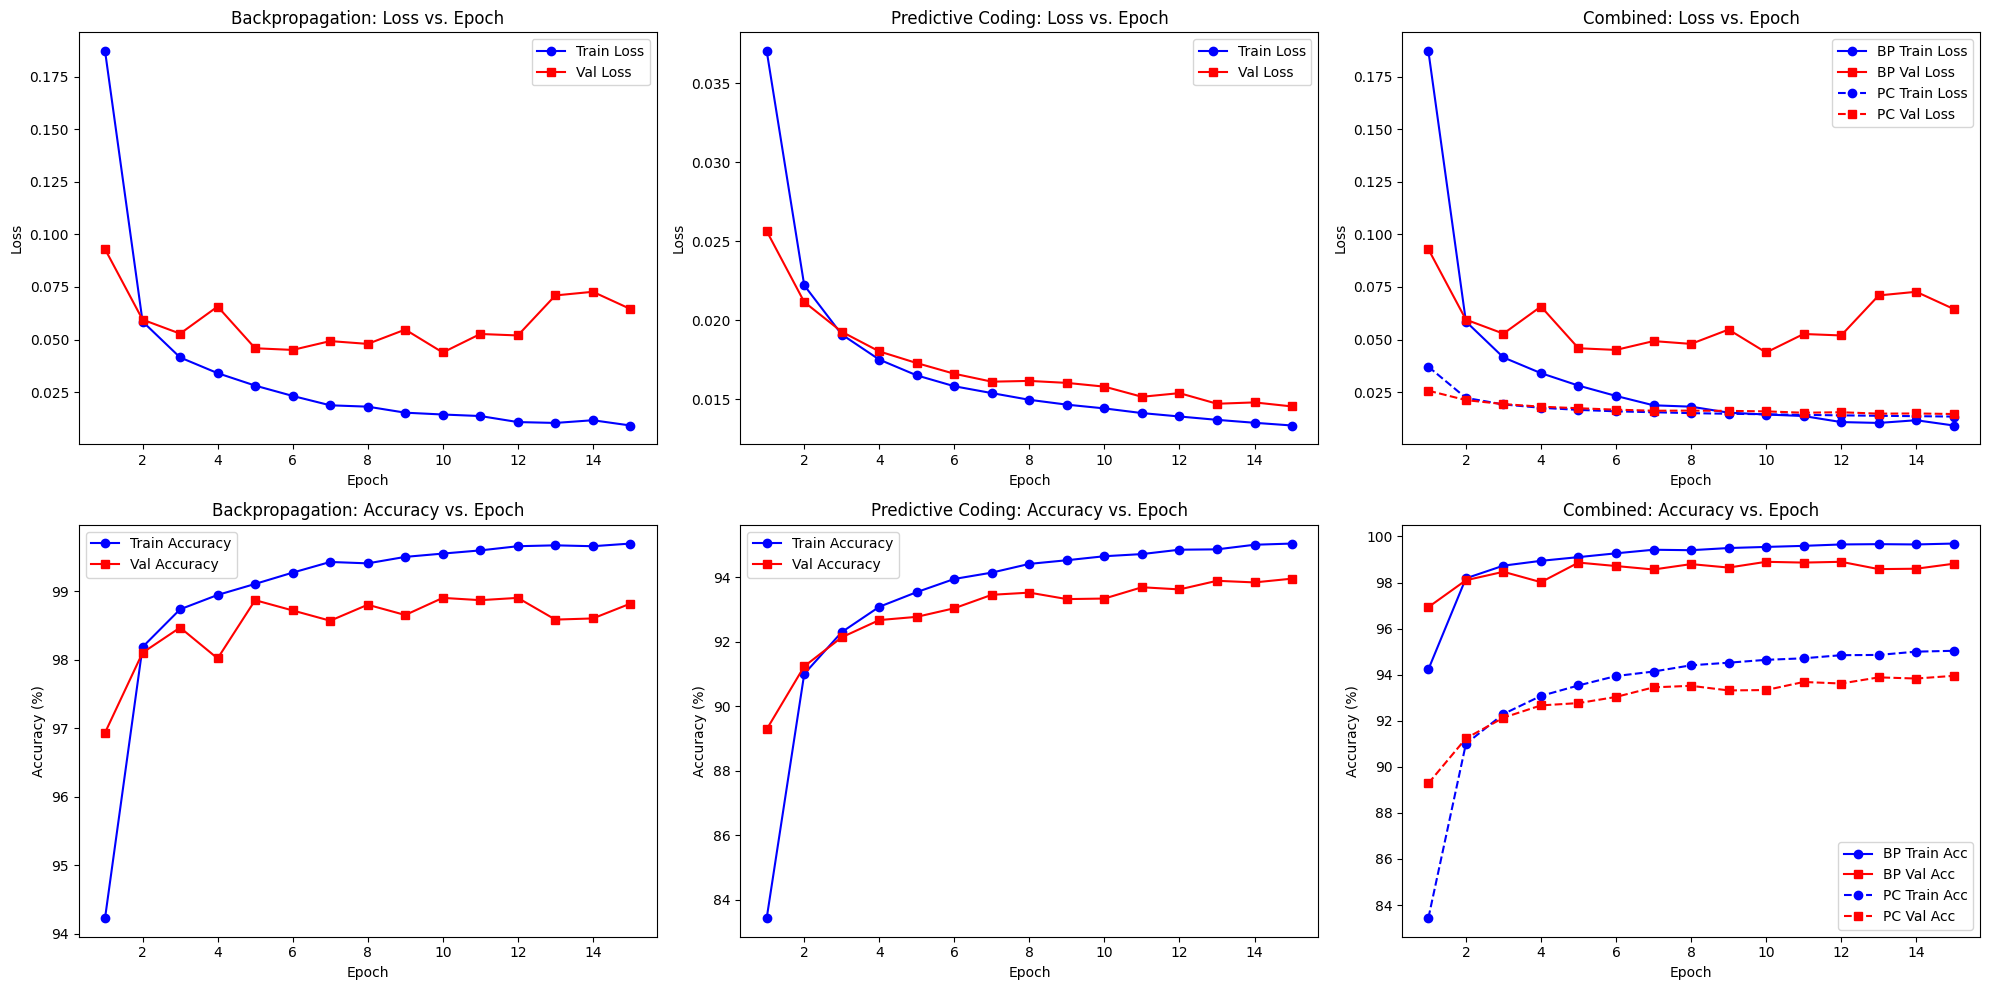

In [43]:
plot_comparison(bp_history, pc_history)

In [ ]:
pd.DataFrame(pc_history)